In [1]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

import json
import pandas as pd
import cv2

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

Using TensorFlow backend.


In [2]:
!curl https://transfer.sh/y7hwul/data_480p_bags.json -o data_480p_bags.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2340M  100 2340M    0     0  14.9M      0  0:02:36  0:02:36 --:--:-- 12.1M


In [ ]:
with open ('data_480p_bags.json', "r") as f:
    data = json.loads(f.read())

In [ ]:
data[0]

In [4]:
df = pd.DataFrame.from_dict(data[0])  

for frame in data[1:]: 
    df = pd.concat([df, pd.DataFrame.from_dict(frame)])
df.head()

ValueError: DataFrame constructor not properly called!

In [ ]:
df = df.drop(['PolygonVerts','Confidence'], axis = 1)
df['id'] = range(0, len(df))

In [ ]:
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
def extract_features(img_crop, model):
    reshaped_img = img_crop.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx)
    return features

In [ ]:
def add_pics(df, video_filename):
    data = {}
    capture = cv2.VideoCapture(os.path.join("./", video_filename))
    
    stamps = list(set(df.Timestamp))    
    
    frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    heigth = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = (capture.get(cv2.CAP_PROP_FOURCC))
    duration = frames_num/fps

    ind = 0 
    for i in stamps:      
        capture.set(cv2.CAP_PROP_POS_FRAMES, i)
        success,frame = capture.read()
            
        if not success:
            print('Error in reading frame %s!!!' %i)
            continue
           
        n = len(df.loc[df['Timestamp'] == i])
        for j in range(n):
            bbox = df.loc[df['Timestamp'] == i].loc[j].BoundingBoxes
            dim = (224, 224)
            img_crop = np.asarray(cv2.resize(frame[bbox[0]:bbox[2], bbox[1]:bbox[3]],
                                                                 dim, interpolation = cv2.INTER_AREA), dtype=np.float64)
            feat = extract_features(img_crop,model)
            data[str(df.loc[df['Timestamp'] == i].loc[j].id)] = feat            
            
            
    return data       

In [5]:
#df_t = df.head(200)
df_t = df
data = add_pics(df_t, 'test_vid_bag.mp4')

filenames = np.array(list(data.keys()))

feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)
            
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=10,n_jobs=-1, random_state=22)
kmeans.fit(x)

NameError: name 'df' is not defined

In [127]:
tuple(df_t.loc[df_t['Timestamp'] == 23].loc[0])

(23, 'book', [247, 44, 321, 81], 0)

In [128]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)


In [181]:
list(df_t.loc[df_t['id']==int(7)].BoundingBoxes)[0]

[109, 519, 146, 559]

In [189]:
def get_miniphoto_from_id(id_item, df, video_filename):
    capture = cv2.VideoCapture(os.path.join("./", video_filename))
    stamp = df.loc[df['id']==int(id_item)].Timestamp.item()
    capture.set(cv2.CAP_PROP_POS_FRAMES, stamp)
    success,frame = capture.read()
    bbox = list(df.loc[df['id']==int(id_item)].BoundingBoxes)[0]
    dim = (256, 256)
    return np.array(cv2.resize(frame[bbox[0]:bbox[2], bbox[1]:bbox[3]],
                                    dim, interpolation = cv2.INTER_AREA))
    

def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of ids for a cluster
    ids = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(ids) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        ids = ids[:29]
    # plot each image in the cluster
    for index, id_item in enumerate(ids):
        plt.subplot(10,10,index+1);
        img = get_miniphoto_from_id(id_item, df_t, 'test.mp4')
        plt.imshow(img)
        plt.axis('off')
        

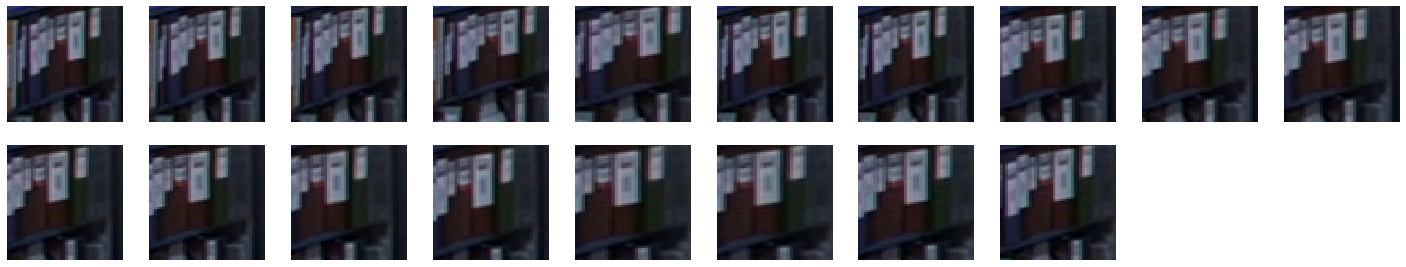

In [190]:
view_cluster(6)

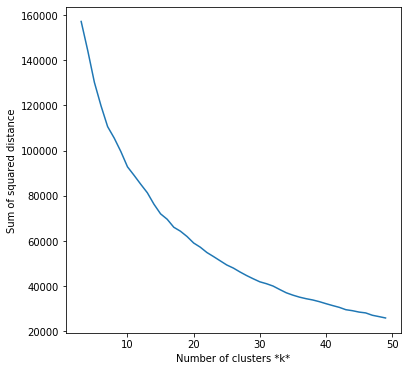

In [191]:
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');